In [113]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. Data cleaning

In [114]:
original = pd.read_csv("../data/BankChurners.csv")
balance_df = pd.read_csv("../data/botswana_bank_customer_churn.csv")
technical_df = pd.read_csv("../data/User churn.csv")

In [115]:
# removing irrelevent columns
original = original.drop(original.columns[[-1, -2]], axis=1)
original = original.drop(columns=['Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Contacts_Count_12_mon','Total_Ct_Chng_Q4_Q1'])

# renaming the datasets
original = original.rename(columns={'Months_on_book' : 'Month_with_bank',
                                    'Total_Relationship_Count' : 'No_of_product',
                                    'Total_Trans_Ct' : 'Total_Trans_Count'})

# removing Na from the dataset
original_Unknown = original[original.isin(['Unknown']).any(axis=1)] # someone handle the unknown please
original = original[~original.isin(['Unknown']).any(axis=1)]


In [116]:
# this function will remove the k,$ and + sign in the income category column
def clean_col(x):
        if 'K' in x:
            return x.replace('K','').replace('$','')
        elif '+' in x:
            return x.replace('+','')
        elif x =='Less than 40':
            return x.split()[2]
        return x
    
original['Income_Category']=original['Income_Category'].apply(clean_col)

In [117]:
# Converting object into category
categorical_features = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
for category in categorical_features:
    original[category] = original[category].astype('category')

# 2. Synthetic data 

## 2.1 Balance dataset

Adding in  `Credit Score`,`Outstanding Loans`, `Balance` from balance dataset. The final dataframe is stored as `final_df`

### 2.1.1 Feature selection

In [118]:
# subsetting from the original data
required_features = ["CLIENTNUM","Customer_Age","Gender","Income_Category","No_of_product"]
subset_original = original.loc[:,required_features]

# subsetting from the income data
required_features2 = ['Date of Birth','Gender','Income','NumOfProducts','Credit Score','Outstanding Loans', 'Balance']
subset_balance = balance_df.loc[:,required_features2]

### 2.1.2 Data Cleaning

In [119]:
# Changing date of birth to date time and them convert it to age
subset_balance['Date of Birth'] = pd.to_datetime(subset_balance['Date of Birth'])
reference_date = pd.Timestamp('2024-01-01')
subset_balance['Date of Birth'] = reference_date.year - subset_balance['Date of Birth'].dt.year

# Changing income into income category
bins = [0, 40000, 60000, 80000, 120000, float('inf')]
labels = ['Less than 40', '40 - 60', '60 - 80', '80 - 120', '120 +']
subset_balance['Income'] = pd.cut(subset_balance['Income'], bins=bins, labels=labels, right=False)

# Recoding Male to M...
subset_balance['Gender'] = subset_balance['Gender'].replace({'Male':'M','Female':'F'})

# Renaming the balance_subset dataframe
subset_balance = subset_balance.rename(columns = {'Date of Birth' : "Customer_Age", 
                                        'Income' : "Income_Category", 'NumOfProducts' : "No_of_product"})

# Converting object to category
subset_balance['Gender'] = subset_balance['Gender'].astype('category')

### 2.1.3 Data Transformation

In [120]:
#Scaling 
scaler = MinMaxScaler()
subset_balance[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_balance[['Customer_Age','No_of_product']])
subset_original[['Customer_Age','No_of_product']] = scaler.fit_transform(subset_original[['Customer_Age','No_of_product']])

# Encode the categorical variables
le_gender = LabelEncoder()
subset_balance['Gender_Encoded'] = le_gender.fit_transform(subset_balance['Gender'])
subset_original['Gender_Encoded'] = le_gender.fit_transform(subset_original['Gender'])

le_income = LabelEncoder()
subset_balance['Income_Category_Encoded'] = le_income.fit_transform(subset_balance['Income_Category'])
subset_original['Income_Category_Encoded'] = le_income.fit_transform(subset_original['Income_Category'])

# Extract relevant features for clustering
features_balance = subset_balance[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]
features_original = subset_original[['Customer_Age', 'No_of_product', 'Gender_Encoded', 'Income_Category_Encoded']]

### 2.1.4 Model Training

In [121]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range = range(2, 7)  # Define the range of cluster numbers to test
inertia_values = []  # Inertia will help determine the optimal cluster number

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_balance)
    inertia_values.append(kmeans.inertia_)

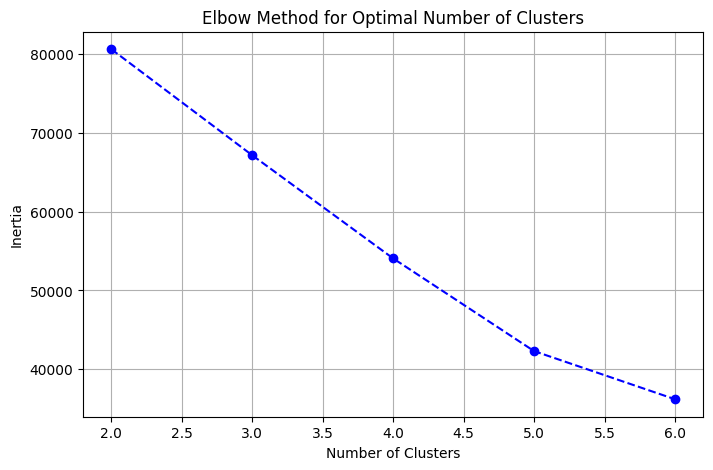

In [122]:
# Plot the elbow method to determine the best cluster count
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [123]:
# Fit the final KMeans model with the selected number of clusters
optimal_k = 5  # Choosen based on the elbow plot
kmeans_final = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_final.fit(features_balance)
subset_balance['Cluster_Labels'] = kmeans_final.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original['Cluster_Labels'] = kmeans_final.predict(features_original)

In [124]:
# List of target variables
target_columns = ['Credit Score','Outstanding Loans', 'Balance']

# Dictionary to hold fitted parameters (mean, std) for each cluster and each target variable
cluster_params = {}

for target in target_columns:
    cluster_params[target] = {}
    # Group by clusters
    for cluster in subset_balance['Cluster_Labels'].unique():
        cluster_data = subset_balance[subset_balance['Cluster_Labels'] == cluster][target]
        # Fit a normal distribution to the data in the cluster
        mean, std = norm.fit(cluster_data)
        cluster_params[target][cluster] = (mean, std)

In [125]:
# Create a function to draw samples based on the cluster label using CLIENTNUM
def generate_synthetic_data_with_clientnum(base_data, cluster_params, target):
    # Initialize a dictionary for storing CLIENTNUM and synthetic values
    synthetic_values = {}
    
    # Iterate over each record in the base data
    for idx, row in base_data.iterrows():
        clientnum = row['CLIENTNUM']  # Fetch the unique identifier
        cluster_label = row['Cluster_Labels']  # Assuming cluster labels are already assigned to base data
        mean, std = cluster_params[target][cluster_label]
        
        # Draw a sample from the normal distribution
        synthetic_value = norm.rvs(loc=mean, scale=std)
        
        # Store the synthetic value with CLIENTNUM as the key
        synthetic_values[clientnum] = synthetic_value
    
    return synthetic_values

# Generate synthetic data for each target variable in the original subset
for target in target_columns:
    synthetic_data = generate_synthetic_data_with_clientnum(subset_original, cluster_params, target)
    
    # Add the synthetic data to the original subset using CLIENTNUM as the identifier
    subset_original[f'{target}'] = subset_original['CLIENTNUM'].map(synthetic_data)

## 2.2 Technical dataset

This section aims to generate artificial data for digital engagement.

### 2.2.1 Feature Selection

In [126]:
required_features_original = ['CLIENTNUM', 'Gender', 'Customer_Age', 'Marital_Status', 'Dependent_count', 'Attrition_Flag']
subset_original2 = original.loc[:,required_features_original]

required_features_tech = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn',
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']
subset_technical = technical_df.loc[:,required_features_tech]

### 2.2.2 Data Cleaning

In [127]:
subset_original2['SeniorCitizen'] = (subset_original2['Customer_Age'] > 60).astype(int)
subset_original2['Dependents'] = subset_original2['Dependent_count'].apply(lambda x: 'Yes' if x > 0 else 'No')

subset_original2.drop(['Customer_Age', 'Dependent_count'], axis = 1, inplace = True)

subset_technical['gender'] = subset_technical['gender'].replace({'Male':'M','Female':'F'})
subset_technical['Churn'] = subset_technical['Churn'].replace({'Attrited Customer':'Yes','Existing Customer':'No'})
subset_technical['Partner'] = subset_technical['Partner'].replace({'Married':'Yes','Single':'No'})

subset_technical = subset_technical.rename(columns = {'gender' : "Gender", 'Churn' : "Attrition_Flag", 'Partner' : "Marital_Status"})

### 2.2.3 Data Transformation

In [128]:
from sklearn.preprocessing import LabelEncoder

# List of categorical features
modified_features_tech = ['Gender', 'SeniorCitizen', 'Marital_Status', 'Dependents', 'Attrition_Flag', 
                          'PhoneService', 'InternetService', 'TechSupport', 'PaperlessBilling', 'PaymentMethod']

# Initialize dictionaries to store encodings
encodings_technical = {}
encodings_original2 = {}

# Encoding for subset_technical
for feature in modified_features_tech:
    # Convert to category type
    subset_technical[feature] = subset_technical[feature].astype('category')
    if feature in subset_original2:
        subset_original2[feature] = subset_original2[feature].astype('category')

# Apply LabelEncoder and show mappings
for feature in modified_features_tech:
    le_technical = LabelEncoder()
    
    # Fit and transform for subset_technical
    subset_technical[feature + '_Encoded'] = le_technical.fit_transform(subset_technical[feature])
    
    # Store the mapping for subset_technical
    encodings_technical[feature] = dict(zip(le_technical.classes_, le_technical.transform(le_technical.classes_)))
    
    # If feature exists in subset_original2, apply encoding
    if feature in subset_original2:
        le_original2 = LabelEncoder()
        subset_original2[feature + '_Encoded'] = le_original2.fit_transform(subset_original2[feature])
        
        # Store the mapping for subset_original2
        encodings_original2[feature] = dict(zip(le_original2.classes_, le_original2.transform(le_original2.classes_)))

features_original2 = subset_original2[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
features_technical = subset_technical[['Gender_Encoded', 'SeniorCitizen_Encoded', 'Marital_Status_Encoded', 'Dependents_Encoded', 'Attrition_Flag_Encoded']]
# Display the encoding mappings
print("Encodings for subset_technical:")
for feature, mapping in encodings_technical.items():
    print(f"{feature}: {mapping}")

print("\nEncodings for subset_original2:")
for feature, mapping in encodings_original2.items():
    print(f"{feature}: {mapping}")

Encodings for subset_technical:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'No': 0, 'Yes': 1}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'No': 0, 'Yes': 1}
PhoneService: {'No': 0, 'Yes': 1}
InternetService: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
TechSupport: {'No': 0, 'No internet service': 1, 'Yes': 2}
PaperlessBilling: {'No': 0, 'Yes': 1}
PaymentMethod: {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}

Encodings for subset_original2:
Gender: {'F': 0, 'M': 1}
SeniorCitizen: {0: 0, 1: 1}
Marital_Status: {'Divorced': 0, 'Married': 1, 'Single': 2}
Dependents: {'No': 0, 'Yes': 1}
Attrition_Flag: {'Attrited Customer': 0, 'Existing Customer': 1}


### 2.2.4 Model Training

In [129]:
# Perform KMeans clustering on balance data and find optimal clusters
cluster_range2 = range(2, 10)  # Define the range of cluster numbers to test
inertia_values2 = []  # Inertia will help determine the optimal cluster number

for k in cluster_range2:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_technical)
    inertia_values2.append(kmeans.inertia_)

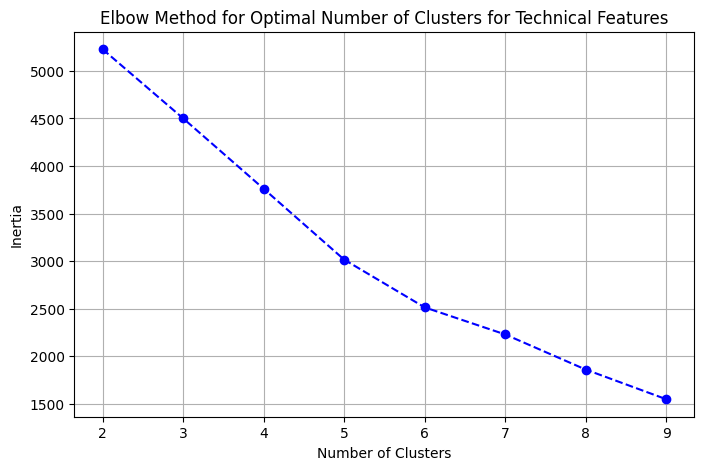

In [130]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range2, inertia_values2, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Number of Clusters for Technical Features')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [131]:
# Fit the final KMeans model with the selected number of clusters
optimal_k_technical = 5  # Choosen based on the elbow plot
kmeans_technical = KMeans(n_clusters=optimal_k, random_state=3101)
kmeans_technical.fit(features_technical)
subset_technical['Cluster_Labels'] = kmeans_technical.labels_

#Predict cluster labels for the original subset using the same KMeans model
subset_original2['Cluster_Labels'] = kmeans_technical.predict(features_original2)

In [132]:
# Calculate the distribution of PhoneService
phone_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['PhoneService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of InternetService
internet_service_distribution = (
    subset_technical.groupby('Cluster_Labels')['InternetService_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of TechSupport
tech_support_distribution = (
    subset_technical.groupby('Cluster_Labels')['TechSupport_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaperlessBilling
paperless_billing_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaperlessBilling_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Calculate the distribution of PaymentMethod
payment_method_distribution = (
    subset_technical.groupby('Cluster_Labels')['PaymentMethod_Encoded']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

In [133]:
def generate_synthetic_features(df, distribution):
    synthetic_feature = []
    
    for _, row in df.iterrows():
        cluster = row['Cluster_Labels']
        
        # Sample a new feature based on the defined probabilities
        sample = np.random.choice(
            distribution.columns,  # Possible features to sample from
            p=distribution.loc[cluster].values  # Probabilities for the respective features
        )
        synthetic_feature.append(sample)
            
    return synthetic_feature

# Generate synthetic features
subset_original2['PhoneService'] = generate_synthetic_features(subset_original2, phone_service_distribution)
subset_original2['InternetService'] = generate_synthetic_features(subset_original2, internet_service_distribution)
subset_original2['TechSupport'] = generate_synthetic_features(subset_original2, tech_support_distribution)
subset_original2['PaperlessBilling'] = generate_synthetic_features(subset_original2, paperless_billing_distribution)
subset_original2['PaymentMethod'] = generate_synthetic_features(subset_original2, payment_method_distribution)

##### Final synthetic dataframe

In [134]:
# Making the final segmentation data for actual segmentation

# Feature from original dataset
feature_from_original = ['CLIENTNUM','Income_Category','No_of_product',
                         'Total_Trans_Amt', 'Total_Trans_Count']
temp1 = original.loc[:,feature_from_original]

# Feature from balance
final_balance_features = ['CLIENTNUM','Credit Score',
       'Outstanding Loans', 'Balance']
temp2 = subset_original.loc[:,final_balance_features]

# Feature from technical
final_tech_features = ['CLIENTNUM','PhoneService','InternetService','TechSupport','PaperlessBilling','PaymentMethod']
temp3  = subset_original2.loc[:,final_tech_features]


# Joingning them all together
temp4 = pd.merge(temp1, temp2, on='CLIENTNUM', how='inner')
final_df = pd.merge(temp4, temp3, on='CLIENTNUM', how = 'inner')

# 3. Customer Segmentation

## 3.1 Feature Engineering Rules

### 3.1.1 Digital Engagement
We will combine the following features to create the `Digital_Engagement` score:
- **PhoneService**: If the customer has phone service (`PhoneService = 1`), add 1 point.
- **InternetService**: 
  - If the customer has **Fiber optic internet** (`InternetService = 1`), add 2 points.
  - If **DSL** (`InternetService = 0`), add 1 point.
- **TechSupport**: 
  - If the customer uses tech support (`TechSupport = 2`), add 2 points.
  - If no tech support (`TechSupport = 0`), add 0 points.
- **PaperlessBilling**: If the customer has paperless billing (`PaperlessBilling = 1`), add 1 point.
- **PaymentMethod**: 
  - If the customer uses **automatic payments** (`PaymentMethod = 0 or 1`), add 2 points.
  - If **electronic check** (`PaymentMethod = 2`), add 1 point.

**Total score range**: 0 to 8 (where 0 means low engagement and 8 means high engagement).

---

### 3.1.3 Financial Status
We will combine the following features to create the `Financial_Status` score:
- **Income_Category**: 
  - If the customer has income in the range `80 - 120` or higher (`120 +`), add 2 points.
  - If `40 - 60`, add 1 point.
- **Credit Score**: 
  - If the credit score is above 700, add 2 points.
  - If between 600 and 700, add 1 point.
- **Outstanding Loans**: 
  - If the loans are less than $20,000, add 2 points.
  - If loans are between $20,000 and $50,000, add 1 point.
- **Balance**: 
  - If the balance is higher than $100,000, add 2 points.
  - If balance is between $50,000 and $100,000, add 1 point.

**Total score range**: 0 to 8 (higher means stronger financial status).

---

### 3.1.3 Transaction Behavior
We will create a composite score for `Transaction_Behavior`:
- **Total_Trans_Amt**: 
  - If the total transaction amount is in the top 25%, add 2 points.
  - If in the middle 50%, add 1 point.
- **Total_Trans_Count**: 
  - If the total number of transactions is in the top 25%, add 2 points.
  - If in the middle 50%, add 1 point.

**Total score range**: 0 to 4 (higher means frequent and high-value transactions).

---

### 3.1.4 Product Usage
We will categorize customers based on the number of products they use and assign them a `Product_Usage` label:
- **Heavy User**: Customers using more than 3 products.
- **Moderate User**: Customers using 2-3 products.
- **Light User**: Customers using 1 product.

In [135]:
### 1. Digital Engagement Score ###
def digital_engagement(row):
    score = 0
    # PhoneService
    if row['PhoneService'] == 1:
        score += 1
    # InternetService
    if row['InternetService'] == 1:  # Fiber optic
        score += 2
    elif row['InternetService'] == 0:  # DSL
        score += 1
    # TechSupport
    if row['TechSupport'] == 2:
        score += 2
    # PaperlessBilling
    if row['PaperlessBilling'] == 1:
        score += 1
    # PaymentMethod
    if row['PaymentMethod'] in [0, 1]:  # Bank transfer or Credit card (automatic)
        score += 2
    elif row['PaymentMethod'] == 2:  # Electronic check
        score += 1
    return score

### 2. Financial Status Score ###
def financial_status(row):
    score = 0
    # Income_Category
    if row['Income_Category'] in ['80 - 120', 'Other']:
        score += 2
    elif row['Income_Category'] == '40 - 60':
        score += 1
    # Credit Score
    if row['Credit Score'] > 700:
        score += 2
    elif 600 <= row['Credit Score'] <= 700:
        score += 1
    # Outstanding Loans
    if row['Outstanding Loans'] < 20000:
        score += 2
    elif 20000 <= row['Outstanding Loans'] < 50000:
        score += 1
    # Balance
    if row['Balance'] > 100000:
        score += 2
    elif 50000 <= row['Balance'] <= 100000:
        score += 1
    return score

### 3. Transaction Behavior Score ###
def transaction_behavior(df, amt_feature, count_feature):
    # Precompute the quantiles for the given transaction amount and count features
    trans_amt_quantiles = df[amt_feature].quantile([0.25, 0.75])
    trans_count_quantiles = df[count_feature].quantile([0.25, 0.75])
    
    def calculate_score(row):
        score = 0
        # Total_Trans_Amt
        if row[amt_feature] > trans_amt_quantiles[0.75]:
            score += 2
        elif row[amt_feature] > trans_amt_quantiles[0.25]:
            score += 1
        # Total_Trans_Count
        if row[count_feature] > trans_count_quantiles[0.75]:
            score += 2
        elif row[count_feature] > trans_count_quantiles[0.25]:
            score += 1
        return score
    
    # Apply the score calculation function to the dataframe
    df['Transaction_Behavior'] = df.apply(calculate_score, axis=1)
    
    return df

### 4. Product Usage ###
def product_usage(row):
    if row['No_of_product'] > 4:
        return 'Heavy User'
    elif 2 <= row['No_of_product'] >= 4:
        return 'Moderate User'
    else:
        return 'Light User'

### Feature Integration: Banking Behavior and Customer Preferences

#### 1. **Banking Behavior**
- **Transaction Behavior**: 
  - Combines total transaction amount and count.
  - High transaction behavior receives a higher score.
  
- **Product Usage**:
  - If the customer is a **Heavy User** of products, they get an additional 2 points.
  - **Moderate Users** get 1 point.
  - **Light Users** don’t add any points.
  
#### 2. **Customer Preferences**
- **Digital Engagement**:
  - Captures how much the customer engages with the bank's digital services.
  - Score based on PhoneService, InternetService, TechSupport, PaperlessBilling, and PaymentMethod.
  
- **Financial Status**:
  - Measures the customer’s financial health based on income, credit score, outstanding loans, and balance.
  
The final **Customer Preferences Score** is the sum of **Digital Engagement** and **Financial Status**.

In [136]:
# Function to combine the individual features into two composite features

def integrate_banking_behavior(row):
    # Combine Transaction Behavior and Product Usage
    banking_behavior_score = row['Transaction_Behavior']
    
    if row['Product_Usage'] == 'Heavy User':
        banking_behavior_score += 2
    elif row['Product_Usage'] == 'Moderate User':
        banking_behavior_score += 1
    # Light users don't add extra points to the banking behavior score
    
    return banking_behavior_score

def integrate_customer_preferences(row):
    # Combine Digital Engagement and Financial Status
    customer_preferences_score = row['Digital_Engagement'] + row['Financial_Status']
    
    return customer_preferences_score


In [137]:
final_df['Digital_Engagement'] = final_df.apply(digital_engagement, axis=1)
final_df['Financial_Status'] = final_df.apply(financial_status, axis=1)
final_df = transaction_behavior(final_df, 'Total_Trans_Amt', 'Total_Trans_Count')
final_df['Product_Usage'] = final_df.apply(product_usage, axis=1)

# Apply the new functions to the dataframe
final_df['Banking_Behavior'] = final_df.apply(integrate_banking_behavior, axis=1)
final_df['Customer_Preferences'] = final_df.apply(integrate_customer_preferences, axis=1)

### Rule-Based Segmentation Based on Banking Behavior and Customer Preferences

#### Classification Ranges:
- **Banking Behavior**:
  - **Low (L)**: Score < 3
  - **Moderate (M)**: Score 3–4(inclusive)
  - **High (H)**: Score > 4

- **Customer Preferences**:
  - **Low (L)**: Score < 6
  - **Moderate (M)**: Score 6–11(inclusive)
  - **High (H)**: Score > 11

#### Segments:

1. **Low Engagement, Low Banking Behavior**:
   - **Banking Behavior**: Low (Score < 3)
   - **Customer Preferences**: Low (Score < 6)
   - **Business Insight**: These customers are disengaged both digitally and financially. Focus on retention through educational programs and targeted basic financial offerings.

2. **Highly Engaged, High Banking Behavior**:
   - **Banking Behavior**: High (Score > 4)
   - **Customer Preferences**: High (Score > 11)
   - **Business Insight**: These customers are highly engaged both financially and digitally. They should be prioritized for premium services, loyalty programs, and personalized offers.

3. **High Engagement, Low or Moderate Banking Behavior**:
   - **Banking Behavior**: Low (Score < 3) or Moderate (Score 3–4)
   - **Customer Preferences**: High (Score > 11)
   - **Business Insight**: These customers are digitally engaged but lack full financial activity. Focus on cross-selling financial products to increase their banking engagement.

4. **High Banking Behavior, Low or Moderate Engagement**:
   - **Banking Behavior**: High (Score > 4)
   - **Customer Preferences**: Low (Score < 6) or Moderate (Score 6–10)
   - **Business Insight**: These customers are financially active but have lower digital engagement. Promote online services or mobile banking to increase digital activity.

5. **Moderate or Low Engagement and Banking Behavior**:
   - **Banking Behavior**: Moderate (Score 3–4) or Low (Score < 3)
   - **Customer Preferences**: Moderate (Score 6–10) or Low (Score < 6)
   - **Business Insight**: These customers have limited engagement both financially and digitally. Focus on retention strategies and encouraging digital services and basic financial products.

In [140]:
# Function to assign clusters based on Banking Behavior and Customer Preferences with thresholds as arguments
def assign_rule_based_cluster(row, banking_thresholds, customer_thresholds):
    banking_low, banking_moderate = banking_thresholds
    customer_low, customer_moderate = customer_thresholds
    
    # Rule 1: Low Engagement, Low Banking Behavior
    if row['Banking_Behavior'] < banking_low and row['Customer_Preferences'] < customer_low:
        return 'Low Engagement, Low Banking Behavior'
    
    # Rule 2: Highly Engaged, High Banking Behavior
    elif row['Banking_Behavior'] > banking_moderate and row['Customer_Preferences'] > customer_moderate:
        return 'Highly Engaged, High Banking Behavior'
    
    # Rule 3: High Engagement, Low or Moderate Banking Behavior
    elif row['Banking_Behavior'] <= banking_moderate and row['Customer_Preferences'] > customer_moderate:
        return 'High Engagement, Low or Moderate Banking Behavior'
    
    # Rule 4: High Banking Behavior, Low or Moderate Engagement
    elif row['Banking_Behavior'] > banking_moderate and row['Customer_Preferences'] <= customer_moderate:
        return 'High Banking Behavior, Low or Moderate Engagement'
    
    # Rule 5: Moderate or Low Engagement and Banking Behavior
    elif row['Banking_Behavior'] <= banking_moderate and row['Customer_Preferences'] <= customer_moderate:
        return 'Moderate or Low Engagement and Banking Behavior'
    
    # Default case: If no specific rule is met
    return 'Other'


In [141]:
banking_thresholds = (3, 4)  # (Low, Moderate)
customer_thresholds = (6, 11)  # (Low, Moderate)

# Apply the function to create the 'Cluster_Labels' column
final_df['Cluster_Labels'] = final_df.apply(assign_rule_based_cluster, axis=1, 
                                            banking_thresholds=banking_thresholds, 
                                            customer_thresholds=customer_thresholds)

# Display the cluster distribution
final_df['Cluster_Labels'].value_counts()

Cluster_Labels
Moderate or Low Engagement and Banking Behavior      5599
High Banking Behavior, Low or Moderate Engagement     643
High Engagement, Low or Moderate Banking Behavior     630
Low Engagement, Low Banking Behavior                  150
Highly Engaged, High Banking Behavior                  59
Name: count, dtype: int64